<a href="https://colab.research.google.com/github/arnold8968/DictateMD/blob/main/DictateMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
# Required libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
from collections import Counter
import numpy as np

In [66]:
!pip install transformers -qqq

In [67]:
!pip install lightgbm --upgrade


# Data Preprocessing

In [ ]:
df = pd.read_csv('./mtsamples.csv')
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4999 non-null   int64 
 1   description        4999 non-null   object
 2   medical_specialty  4999 non-null   object
 3   sample_name        4999 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3931 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB


In [ ]:
# Drop rows with NaN values in the "transcription" column
df = df.dropna(subset=['transcription'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4966 entries, 0 to 4998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4966 non-null   int64 
 1   description        4966 non-null   object
 2   medical_specialty  4966 non-null   object
 3   sample_name        4966 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3898 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.6+ KB


 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

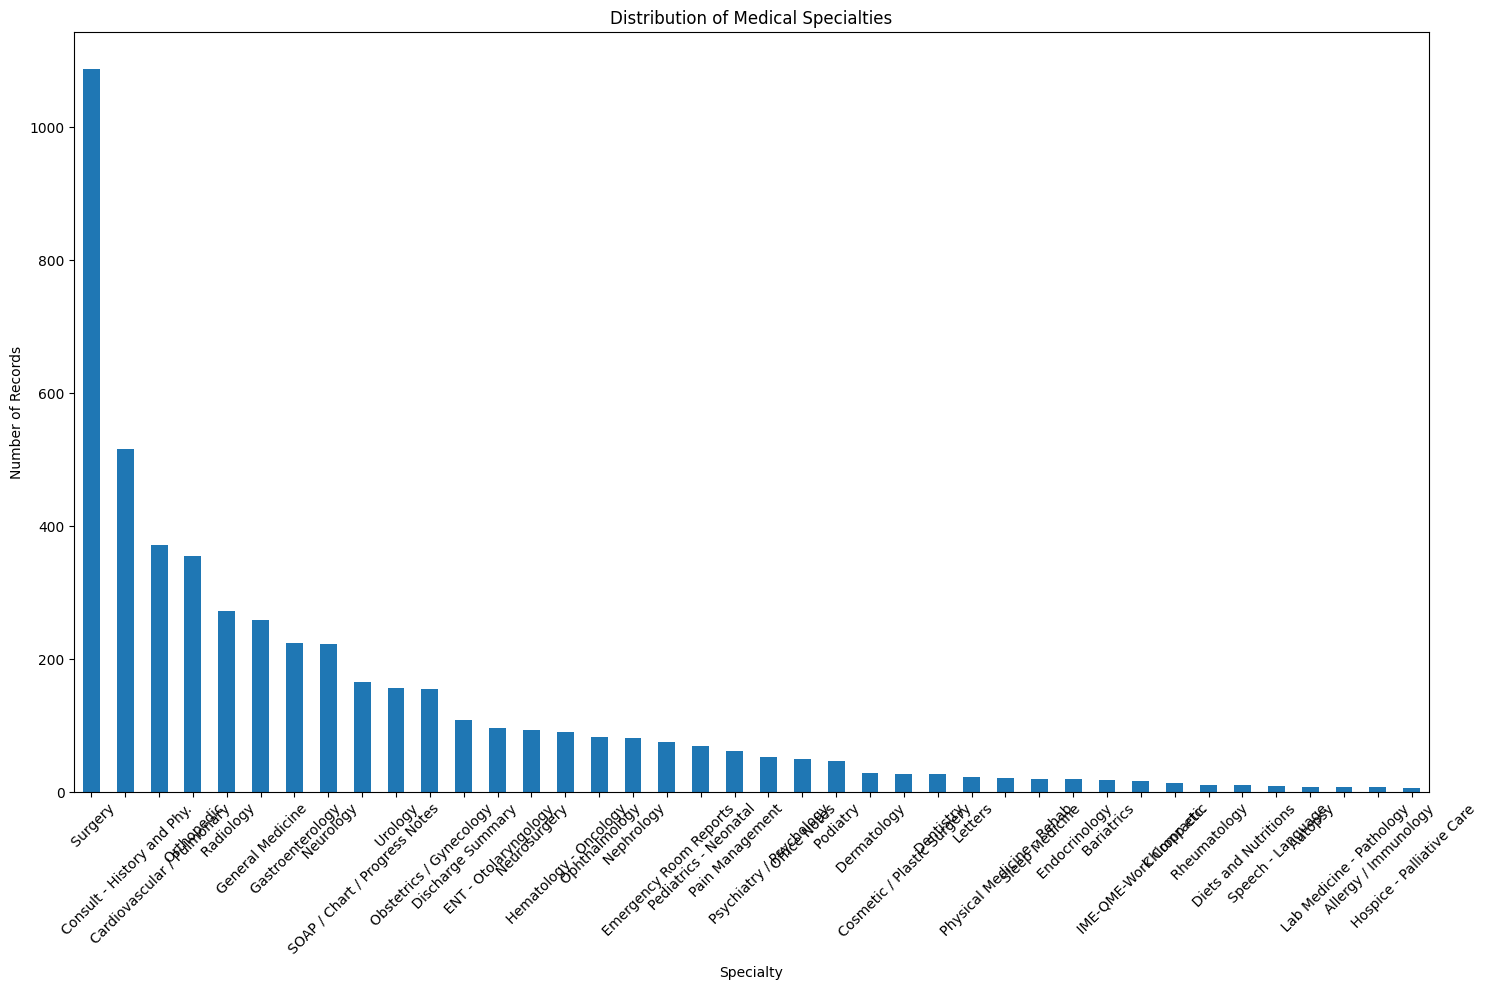

In [ ]:
# Feature medical_specialty

unique_specialties = df['medical_specialty'].nunique()
specialty_counts = df['medical_specialty'].value_counts()
print(specialty_counts)

# Visualizing the distribution of 'medical_specialty' categories
plt.figure(figsize=(15,10))
specialty_counts.plot(kind='bar')
plt.title('Distribution of Medical Specialties')
plt.xlabel('Specialty')
plt.ylabel('Number of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### The dataset is uneven distributions. Need to handle the class imbalance problem

In [ ]:
# Feature keywords for each category

combined_keywords = df.groupby('medical_specialty')['keywords'].apply(lambda x: ', '.join(filter(lambda y: isinstance(y, str), x))).reset_index()
combined_keywords['keyword_list'] = combined_keywords['keywords'].apply(lambda x: set([word.strip() for word in x.split(",") if word.strip() != '']))

for i in range(len(combined_keywords)):
  print(combined_keywords['medical_specialty'][i])
  print(combined_keywords['keyword_list'][i])



 Allergy / Immunology
{'allergy / immunology', 'probable food allergies', 'allergies', 'xerostomia', 'rast', 'nasal', 'allergic rhinitis', 'nasal sprays', 'conjunctivitis', 'rast allergy testing', 'vaccine', 'allergy', 'allergic', 'inhalant', 'aspirin', 'erythematous', 'probable environmental inhalant allergies', 'mucous membranes', 'sprays', 'allegra', 'chronic glossitis', 'environmental inhalant allergies', 'ad lib', 'food', 'kawasaki disease', 'fever', 'asthma', 'rhinitis'}
 Autopsy
set()
 Bariatrics
{'lap banding', 'implant', 'gastric bypass surgery', 'medifast diet', 'diabetes', 'liquid diet', 'richard simmons', 'pounds', 'drain site', 'supermorbid obesity', 'reconstruction', 'hypertension', 'varicose', 'sleep study', 'weight', 'esophagogastroduodenoscopy', 'bariatric clear liquids', 'medifast dieting', 'weight loss modalities', 'evaluation for bariatric surgery', 'tops', 'bariatrics', 'surgical weight loss', 'umbilicus', 'anastamosis', 'lost', 'bypass', 'cabbage diet', 'body weig

In [ ]:
# Feature keywords for each category

combined_sample = df.groupby('medical_specialty')['sample_name'].apply(lambda x: ', '.join(filter(lambda y: isinstance(y, str), x))).reset_index()
combined_sample['sample_name_list'] = combined_sample['sample_name'].apply(lambda x: set([word.strip() for word in x.split(",") if word.strip() != '']))

for i in range(len(combined_sample)):
  print(combined_sample['medical_specialty'][i])
  print(combined_sample['sample_name_list'][i])
  print(len(combined_sample['sample_name_list'][i]))



 Allergy / Immunology
{'Allergic Rhinitis', 'Allergy Evaluation Consult', 'Chronic Sinusitis', 'Kawasaki Disease - Discharge Summary', 'Followup on Asthma', 'Evaluation of Allergies', 'Asthma in a 5-year-old'}
7
 Autopsy
{'Autopsy - 1', 'Autopsy - 7', 'Autopsy - 2', 'Autopsy - 6', 'Autopsy - 4', 'Autopsy - 8', 'Autopsy - 5', 'Autopsy - 3'}
8
 Bariatrics
{'Laparoscopic Gastric Bypass Consult - 2', 'Gastric Bypass - Preop Eval', 'Liposuction', 'Gastric Bypass Discussion - 2', 'Gastric Bypass Summary', 'Laparoscopic Gastric Banding - Preop Visit', 'Gastric Bypass Discussion - 3', 'Bariatric Consult - Surgical Weight Loss - 2', 'Discharge Summary - Gastric Bypass', 'Bariatric Consult - Surgical Weight Loss - 4', 'Laparoscopic Gastric Bypass Consult - 1', 'Lipectomy - Abdomen/Thighs', 'Bariatric Consult - Surgical Weight Loss - 1', 'Bariatric Consult - Surgical Weight Loss - 3', 'Gastric Bypass Discussion - 1', 'Laparoscopic Gastric Bypass - 1', 'Laparoscopic Gastric Bypass', 'Lap Band Adju

## Over-sampling the Minority Class


Classes with counts < 100. Consider over-sampling them to 100.

There are other over-sampling methods, such as data augmentation. Couse of time, using simple one

In [ ]:
import pandas as pd
from sklearn.utils import resample


oversampled_data = pd.DataFrame()
target_count = 100

# Loop over categories and oversample
for category, count in df['medical_specialty'].value_counts().items():
    if count < 100:

        category_data = df[df['medical_specialty'] == category]
        oversampled_category_data = resample(category_data,
                                             replace=True,
                                             n_samples=target_count - count,
                                             random_state=42)

        oversampled_data = pd.concat([oversampled_data, oversampled_category_data])

df_oversampled = pd.concat([df, oversampled_data])

df_oversampled = df_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

df_oversampled['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 Pain Management                   100
 Ophthalmology                     100
 Nephrology                        100
 IME-QME-Work Comp etc.            100
 Hospice - Palliative Care         100
 Pediatrics - Neonatal             100
 Speech - Language                 100
 Diets and Nutritions              100
 Rheumatology                      100
 Endocrinology                     100
 Autopsy                           100
 Physical Medicine - Rehab         100
 Podiatry                          100
 Letters                 

# 2. Text processing

## 2.1 Preprocess the text data

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]

    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    tokens = [token for token in tokens if token.isalpha()]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

df_oversampled['preprocessed_transcription'] = df_oversampled['transcription'].apply(preprocess_text)


In [ ]:
df_oversampled.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,preprocessed_transcription
0,3100,Occupational medicine consult with questions-...,IME-QME-Work Comp etc.,Occupational Medicine Consult,"ALLOWED CONDITION: , Right shoulder sprain and...",NaN,allowed condition right shoulder sprain right ...
1,1096,Cardiac catheterization and coronary interven...,Surgery,Cardiac Catheterization - 9,"EXAM: , Cardiac catheterization and coronary i...",NaN,exam cardiac catheterization coronary interven...
2,3085,"Specimen labeled ""sesamoid bone left foot"".",Lab Medicine - Pathology,Pathology - Sesamoid Bone,"GROSS DESCRIPTION: , Specimen labeled ""sesamoi...","lab medicine - pathology, marrow fibrosis, ost...",gross description specimen labeled sesamoid bo...
3,4980,Evaluation for elective surgical weight loss ...,Bariatrics,Bariatric Consult - Surgical Weight Loss - 1,"PAST MEDICAL HISTORY: , She has a history of h...","bariatrics, elective surgical weight loss, sur...",past medical history history hypertension shor...
4,4995,This is a 14-month-old baby boy Caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","allergy / immunology, mucous membranes, conjun...",admitting diagnosis kawasaki discharge diagnos...


In [ ]:
# df_oversampled.info()

## 2.2 Exploratory Data Analysis

In [ ]:
def word_frequency_analysis(df):
    category_word_freq = defaultdict(lambda: defaultdict(int))

    for _, row in df.iterrows():
        category = row['medical_specialty']
        tokens = row['preprocessed_transcription'].split() if isinstance(row['preprocessed_transcription'], str) else []

        for token in tokens:
            category_word_freq[category][token] += 1

    return category_word_freq

word_freq = word_frequency_analysis(df_oversampled)

for category, freq_dict in word_freq.items():
    print("{} - Most Common Terms:".format(category))
    sorted_terms = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)
    for term, freq in sorted_terms[:10]:
        print("{}: {}".format(term, freq))

 IME-QME-Work Comp etc. - Most Common Terms:
pain: 823
right: 750
patient: 652
back: 589
injury: 491
left: 482
knee: 397
also: 394
history: 380
examination: 380
 Surgery - Most Common Terms:
patient: 5339
procedure: 3323
right: 3194
left: 3183
placed: 3004
incision: 1776
using: 1754
diagnosis: 1664
anesthesia: 1616
well: 1559
 Lab Medicine - Pathology - Most Common Terms:
tumor: 421
lobe: 392
cm: 389
right: 387
lymph: 375
node: 342
x: 319
upper: 277
lung: 219
specimen: 207
 Bariatrics - Most Common Terms:
patient: 322
history: 308
also: 229
weight: 193
surgery: 171
gastric: 160
abdomen: 128
loss: 128
placed: 124
procedure: 119
 Allergy / Immunology - Most Common Terms:
history: 521
allergy: 377
patient: 343
without: 188
past: 169
noted: 169
mass: 164
nasal: 159
medical: 158
medication: 157
 Gastroenterology - Most Common Terms:
patient: 968
procedure: 481
history: 338
normal: 302
placed: 296
diagnosis: 258
abdomen: 227
colon: 225
well: 224
right: 195
 Consult - History and Phy. - Most 

In [ ]:
# Analyze ngram frequency by category.
from collections import defaultdict, Counter
from nltk.util import ngrams

def ngram_frequency_analysis(df, n=2):

    category_ngram_freq = defaultdict(Counter)

    for _, row in df.iterrows():
        category = row['medical_specialty']
        tokens = row['preprocessed_transcription'].split() if isinstance(row['preprocessed_transcription'], str) else []

        n_grams = list(ngrams(tokens, n))
        for n_gram in n_grams:
            category_ngram_freq[category][n_gram] += 1

    return category_ngram_freq

ngram_freq = ngram_frequency_analysis(df_oversampled, 2)

for category, freq_dict in ngram_freq.items():
    print("{} - Most Common N-grams:".format(category))
    sorted_ngrams = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)
    for ngram, freq in sorted_ngrams[:10]:
        print(f"{' '.join(ngram)}: {freq}")



 IME-QME-Work Comp etc. - Most Common N-grams:
left knee: 233
back pain: 207
upper extremity: 183
range motion: 146
allowed condition: 121
right upper: 111
injured worker: 104
physical therapy: 99
physical examination: 93
thoracic spine: 91
 Surgery - Most Common N-grams:
preoperative diagnosis: 757
postoperative diagnosis: 739
prepped draped: 693
operating room: 689
incision made: 532
procedure patient: 528
tolerated procedure: 511
procedure well: 485
patient tolerated: 456
blood loss: 439
 Lab Medicine - Pathology - Most Common N-grams:
lymph node: 342
upper lobe: 263
right upper: 224
x cm: 187
x x: 104
lower lobe: 93
right lower: 84
received fresh: 81
measuring x: 79
lobe lung: 72
 Bariatrics - Most Common N-grams:
gastric bypass: 110
weight loss: 105
laparoscopic gastric: 66
family history: 57
physical examination: 53
blood pressure: 48
potential complication: 46
mg daily: 44
morbid obesity: 43
pulmonary embolism: 43
 Allergy / Immunology - Most Common N-grams:
allergic reaction: 9

Medical specialty contains some specific terminology, such as:

Allergy / Immunology frequently mentions terms like allergy, nasal.

Cardiovascular / Pulmonary frequently mentions terms like artery, coronary, chest

Dentistry has words like tooth, teeth, and dental, which are expected.

It means that there is a certain degree of distinction between different categories

# 3. Training preparetion

## 3.1 Word embedding

In [ ]:
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model = model.to('cuda')

def get_bert_embeddings(texts):
    inputs = tokenizer(texts, return_tensors="pt", add_special_tokens=True, truncation=True, padding=True, max_length=512)
    inputs = {key: val.to('cuda') for key, val in inputs.items()}  # Move inputs to GPU

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return embeddings


batch_size = 32
embeddings = []

for i in range(0, len(df_oversampled), batch_size):
    batch_texts = df_oversampled['preprocessed_transcription'].iloc[i:i+batch_size].tolist()
    batch_embeddings = get_bert_embeddings(batch_texts)
    embeddings.extend(batch_embeddings)

df_oversampled['transcription_embedding'] = embeddings


In [ ]:
df_oversampled.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,preprocessed_transcription,transcription_embedding
0,3100,Occupational medicine consult with questions-...,IME-QME-Work Comp etc.,Occupational Medicine Consult,"ALLOWED CONDITION: , Right shoulder sprain and...",NaN,allowed condition right shoulder sprain right ...,"[-0.7284693, 0.016075576, -0.10792584, -0.3774..."
1,1096,Cardiac catheterization and coronary interven...,Surgery,Cardiac Catheterization - 9,"EXAM: , Cardiac catheterization and coronary i...",NaN,exam cardiac catheterization coronary interven...,"[-0.38439587, -0.056256093, -0.004836315, -0.2..."
2,3085,"Specimen labeled ""sesamoid bone left foot"".",Lab Medicine - Pathology,Pathology - Sesamoid Bone,"GROSS DESCRIPTION: , Specimen labeled ""sesamoi...","lab medicine - pathology, marrow fibrosis, ost...",gross description specimen labeled sesamoid bo...,"[-0.48820022, 0.057362143, 0.19512302, -0.0678..."
3,4980,Evaluation for elective surgical weight loss ...,Bariatrics,Bariatric Consult - Surgical Weight Loss - 1,"PAST MEDICAL HISTORY: , She has a history of h...","bariatrics, elective surgical weight loss, sur...",past medical history history hypertension shor...,"[-0.26834473, 0.19860122, 0.23104122, -0.03660..."
4,4995,This is a 14-month-old baby boy Caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","allergy / immunology, mucous membranes, conjun...",admitting diagnosis kawasaki discharge diagnos...,"[-0.27686808, -0.30850995, 0.29437312, -0.2531..."


In [ ]:
df_oversampled.to_csv('./mtsamples_embedding.csv')

# 4. Model Building

In [75]:
# train_test_split
from sklearn.model_selection import train_test_split

X = np.vstack(df_oversampled['transcription_embedding'].values)
y = df_oversampled['medical_specialty'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4.1 Simple baseline model

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, matthews_corrcoef, log_loss

X_train = np.array(X_train, dtype=float)
X_test = np.array(X_test, dtype=float)


# 1. Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)

print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Classification Report:\n", classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))

Logistic Regression Results:
Accuracy: 0.39133681852128455
Classification Report:
                                 precision    recall  f1-score   support

          Allergy / Immunology       0.88      1.00      0.94        22
                       Autopsy       1.00      1.00      1.00        20
                    Bariatrics       0.75      1.00      0.86        12
    Cardiovascular / Pulmonary       0.17      0.13      0.15        85
                  Chiropractic       0.81      0.81      0.81        21
    Consult - History and Phy.       0.17      0.19      0.18       110
    Cosmetic / Plastic Surgery       0.50      0.53      0.51        17
                     Dentistry       0.69      0.87      0.77        23
                   Dermatology       0.62      0.75      0.68        20
          Diets and Nutritions       0.78      1.00      0.88        18
             Discharge Summary       0.14      0.11      0.12        27
          ENT - Otolaryngology       0.06      0.08 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The ROC-AUC, Log-Loss, and MCC are best suited for binary classification problems. This is a multi-class problem, these might not be directly applicable.


The accuracy of your model is approximately 39.13%. Depending on the context and the importance of the task, this might be considered as a moderate performance.

The specialties Allergy / Immunology, Autopsy, Hospice - Palliative Care, Lab Medicine - Pathology, Speech - Language have high precision, recall, and F1-scores.


Categories like General Medicine, Cardiovascular / Pulmonary, Consult - History and Phy., Gastroenterology, Orthopedic, Radiology, Surgery, etc. have low precision, recall, and F1-scores.

In [ ]:
# 2. Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("\nRandom Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Results:
Accuracy: 0.33831217326362956
Classification Report:
                                 precision    recall  f1-score   support

          Allergy / Immunology       0.88      1.00      0.94        22
                       Autopsy       1.00      1.00      1.00        20
                    Bariatrics       0.75      1.00      0.86        12
    Cardiovascular / Pulmonary       0.03      0.02      0.03        85
                  Chiropractic       0.81      0.81      0.81        21
    Consult - History and Phy.       0.09      0.09      0.09       110
    Cosmetic / Plastic Surgery       0.67      0.82      0.74        17
                     Dentistry       0.68      0.83      0.75        23
                   Dermatology       0.69      0.90      0.78        20
          Diets and Nutritions       0.72      1.00      0.84        18
             Discharge Summary       0.00      0.00      0.00        27
          ENT - Otolaryngology       0.05      0.08      

Xgboost

In [64]:
!pip install xgboost

In [71]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


param = {
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y_train)),
    'booster': 'gbtree',
    'eval_metric': 'mlogloss',
    'eta': 0.1,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'max_depth': 6
}

num_round = 100
watchlist = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds=10)

y_pred_prob = bst.predict(dtest)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mlogloss:3.18095	eval-mlogloss:3.33836
[1]	train-mlogloss:2.85325	eval-mlogloss:3.12351
[2]	train-mlogloss:2.59987	eval-mlogloss:2.96109
[3]	train-mlogloss:2.39531	eval-mlogloss:2.83779
[4]	train-mlogloss:2.23193	eval-mlogloss:2.73881
[5]	train-mlogloss:2.08684	eval-mlogloss:2.65426
[6]	train-mlogloss:1.96458	eval-mlogloss:2.58242
[7]	train-mlogloss:1.85439	eval-mlogloss:2.52255
[8]	train-mlogloss:1.75751	eval-mlogloss:2.46989
[9]	train-mlogloss:1.67345	eval-mlogloss:2.42447
[10]	train-mlogloss:1.59560	eval-mlogloss:2.38449
[11]	train-mlogloss:1.52641	eval-mlogloss:2.34941
[12]	train-mlogloss:1.46317	eval-mlogloss:2.32196
[13]	train-mlogloss:1.40661	eval-mlogloss:2.29557
[14]	train-mlogloss:1.35431	eval-mlogloss:2.27101
[15]	train-mlogloss:1.30691	eval-mlogloss:2.25095
[16]	train-mlogloss:1.26313	eval-mlogloss:2.23332
[17]	train-mlogloss:1.22322	eval-mlogloss:2.21826
[18]	train-mlogloss:1.18621	eval-mlogloss:2.20263
[19]	train-mlogloss:1.15275	eval-mlogloss:2.19083
[20]	train

In [74]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        22
           1       1.00      1.00      1.00        20
           2       0.75      1.00      0.86        12
           3       0.06      0.04      0.04        85
           4       0.81      0.81      0.81        21
           5       0.09      0.08      0.08       110
           6       0.56      0.59      0.57        17
           7       0.68      0.83      0.75        23
           8       0.65      0.75      0.70        20
           9       0.78      1.00      0.88        18
          10       0.05      0.04      0.04        27
          11       0.05      0.08      0.06        13
          12       0.30      0.23      0.26        26
          13       0.79      1.00      0.88        22
          14       0.04      0.02      0.02        57
          15       0.04      0.04      0.04        48
          16       0.00      0.00      0.00        20
          17       0.88    

Xgboost VS Logistic Regression.



High Precision/Recall/F1 Categories:

Both models tend to perform quite well for certain categories. Categories like "Allergy / Immunology", "Autopsy", "Bariatrics", and "Lab Medicine - Pathology".

This could be:

Clear feature separation for these categories

A decent amount of data to learn from,


Low Precision/Recall/F1 Categories:

However, there are categories where both models perform poorly. For example, "Cardiovascular / Pulmonary", "Consult - History and Phy.", "Gastroenterology", and "General Medicine" have low scores.

This could be:

Overlapping features with other categories,

Insufficient data to make confident predictions,

High class imbalance,

Noise in the data.


Differences in Predictions:


There are differences in how each model approaches certain categories:

For "Dermatology", XGBoost has a higher precision, recall, and F1-score compared to Logistic Regression.
Conversely, for categories like "Emergency Room Reports", Logistic Regression outperforms XGBoost.



# 4.2 Advanced Model BERT

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder


In [79]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)



In [80]:
# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [81]:
# uses a three-layer feedforward neural network to classify the BERT embeddings
class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [84]:
model = Classifier(X_train.shape[1], len(encoder.classes_))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")



Epoch 1/20, Loss: 2.95653734320686
Epoch 2/20, Loss: 2.3354664835191907
Epoch 3/20, Loss: 2.0336096570605324
Epoch 4/20, Loss: 1.8306849059604464
Epoch 5/20, Loss: 1.678605539103349
Epoch 6/20, Loss: 1.568956980747836
Epoch 7/20, Loss: 1.4685710186050052
Epoch 8/20, Loss: 1.412562377396084
Epoch 9/20, Loss: 1.3383251123485111
Epoch 10/20, Loss: 1.3001087173109962
Epoch 11/20, Loss: 1.257176155135745
Epoch 12/20, Loss: 1.2236838816177278
Epoch 13/20, Loss: 1.1995632375280063
Epoch 14/20, Loss: 1.1650598105930148
Epoch 15/20, Loss: 1.1539294258469628
Epoch 16/20, Loss: 1.1315482177195095
Epoch 17/20, Loss: 1.0883947419268745
Epoch 18/20, Loss: 1.0803125724196434
Epoch 19/20, Loss: 1.0527522599413282
Epoch 20/20, Loss: 1.0504524154322488


In [85]:
# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=encoder.classes_))


Accuracy: 0.4421209858103062
Classification Report:
                                 precision    recall  f1-score   support

          Allergy / Immunology       0.88      1.00      0.94        22
                       Autopsy       1.00      1.00      1.00        20
                    Bariatrics       0.75      1.00      0.86        12
    Cardiovascular / Pulmonary       0.27      0.12      0.16        85
                  Chiropractic       0.68      0.90      0.78        21
    Consult - History and Phy.       0.25      0.35      0.30       110
    Cosmetic / Plastic Surgery       0.63      0.71      0.67        17
                     Dentistry       0.71      0.96      0.81        23
                   Dermatology       0.67      1.00      0.80        20
          Diets and Nutritions       0.78      1.00      0.88        18
             Discharge Summary       0.19      0.15      0.17        27
          ENT - Otolaryngology       0.07      0.08      0.07        13
        Em

In [91]:
#bert_result
report_str = classification_report(all_labels, all_preds, target_names=encoder.classes_, output_dict=True)

bert_df = pd.DataFrame(report_str).transpose()

In [93]:
bert_df['num_count'] = df_oversampled['medical_specialty'].value_counts()

In [94]:
bert_df

,precision,recall,f1-score,support,num_count
Allergy / Immunology,0.880000,1.000000,0.936170,22.000000,100.0
Autopsy,1.000000,1.000000,1.000000,20.000000,100.0
Bariatrics,0.750000,1.000000,0.857143,12.000000,100.0
Cardiovascular / Pulmonary,0.270270,0.117647,0.163934,85.000000,371.0
Chiropractic,0.678571,0.904762,0.775510,21.000000,100.0
Consult - History and Phy.,0.254902,0.354545,0.296578,110.000000,516.0
Cosmetic / Plastic Surgery,0.631579,0.705882,0.666667,17.000000,100.0
Dentistry,0.709677,0.956522,0.814815,23.000000,100.0
Dermatology,0.666667,1.000000,0.800000,20.000000,100.0
Diets and Nutritions,0.782609,1.000000,0.878049,18.000000,100.0


BERT has a higher overall accuracy than simple baseline model

By examining specific classes:

For some classes, both BERT and XGBoost have achieved high performance. For example, in "Allergy / Immunology", both models have high precision, recall, and f1-score.

However, in classes like "Neurology" or "Surgery", BERT has achieved a better precision and recall compared to XGBoost.

It's important to note that there are some classes where XGBoost has extremely low or even zero precision and recall, like in "Hematology - Oncology" or "Obstetrics / Gynecology". This indicates that XGBoost has difficulties predicting those classes correctly, while BERT might perform a bit better.

BERT has outperformed XGBoost in terms of overall accuracy, macro averages, and weighted averages. Additionally, for many individual classes, BERT has shown better precision, recall, and F1-scores. However, there are still classes where both models struggle, indicating potential areas of improvement. Considerations like the imbalance in the dataset, potential resampling strategies, or more fine-tuning could further improve the model's performance.

How to improve:


Data Augmentation: For categories with low scores, consider collecting more data or data augmentation techniques to enhance the dataset.

Feature Engineering

Experiment with More Models

Experiment with More embedding models

Class Imbalance